In [1]:
#| hide
# skip
! [ -e /content ] && pip install -Uqq model_inspector nbdev
# For colab. Restart the runtime after running this cell!

In [2]:
#| default_exp inspect.classifier

# Classifier

> Inspector functionality for any classification model

In [3]:
#| export
from typing import Callable, Optional, Sequence, Union

import numpy as np
import pandas as pd
import sklearn
from model_inspector.delegate import delegates
from model_inspector.inspect.any_model import _Inspector
from model_inspector.tune import (
    calculate_metrics_by_thresh_binary,
    calculate_metrics_by_thresh_multi,
    confusion_matrix,
)

In [4]:
#| export
class _ClasInspector(_Inspector):
    """Abstract class for classification model inspectors"""
    def calculate_metrics_by_thresh(*args, **kwargs):
        raise NotImplementedError()
        
    def confusion_matrix(*args, **kwargs):
        raise NotImplementedError()

## Binary Classification

In [5]:
#| export
class _BinInspector(_ClasInspector):
    """Binary classification model inspector"""
    
    def calculate_metrics_by_thresh(
        self,
        metrics: Union[Callable, Sequence[Callable]],
        thresholds: Optional[Sequence] = None,
    ) -> pd.DataFrame:
        """Calculate classification metrics as a function of threshold

        Assumes that `self.model` has a `.predict_proba()` method. Uses
        `self.y` as ground-truth values,
        `self.model.predict_proba(self.X)[:, 1] > thresh` as
        predictions.

        Parameters:
        - `metrics`: Callables that take `y_true`, `y_pred` as
        positional arguments and return a number. Must have a `__name__`
        attribute.
        - `thresholds`: `Sequence` of `float` threshold values to use. By
        default uses `0` and the values that appear in `y_prob[:, 1]`, which
        is a minimal set that covers all of the relevant possibilities. One
        reason to override that default would be to save time with a large
        dataset.

        Returns: DataFrame with one column "thresh" indicating the
        thresholds used and an additional column for each input metric
        giving the value of that metric at that threshold.
        """
        return calculate_metrics_by_thresh_binary(
            y_true=self.y,
            y_prob=self.model.predict_proba(self.X),
            metrics=metrics,
            thresholds=thresholds,
        )

    @delegates(sklearn.metrics.confusion_matrix)
    def confusion_matrix(
        self,
        thresh: float = 0.5,
        **kwargs,
    ) -> pd.DataFrame:
        """Get confusion matrix

        Assumes that `self.model` has a `.predict_proba()` method. Uses
        `self.y` as ground-truth values,
        `self.model.predict_proba(self.X)[:, 1] > thresh` as
        predictions.

        If output is not rendering properly when you reopen a notebook,
        make sure the notebook is trusted.

        Parameters:
        - `thresh`: Probability threshold for counting a prediction as
        positive
        """
        labels = np.unique(self.y)
        return confusion_matrix(
            y_true=self.y,
            y_pred=np.where(
                self.model.predict_proba(self.X)[:, 1] > thresh, labels[1], labels[0]
            ),
            **kwargs,
        )

In [6]:
import sklearn.datasets
from model_inspector import get_inspector
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X, y = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)
inspector = get_inspector(
    RandomForestClassifier().fit(X_train, y_train),
    X_test,
    y_test,
)

metrics_by_thresh = inspector.calculate_metrics_by_thresh(
    metrics=[metrics.precision_score, metrics.recall_score, metrics.f1_score],
)
metrics_by_thresh.head()

  0%|                                                                                                                                | 0/44 [00:00<?, ?it/s]/Users/greg.gandenberger/.pyenv/versions/3.11.2/envs/model_inspector311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 706.72it/s]


,thresh,precision_score,recall_score,f1_score
0,0.00,0.704918,1.0,0.826923
1,0.00,0.704918,1.0,0.826923
2,0.01,0.735043,1.0,0.847291
3,0.02,0.761062,1.0,0.864322
4,0.03,0.767857,1.0,0.868687


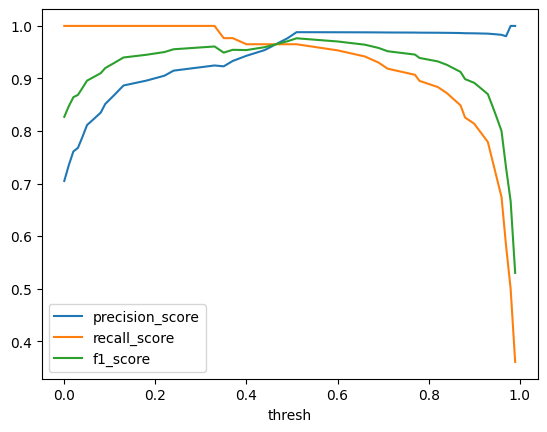

In [7]:
ax = metrics_by_thresh.iloc[:-1].plot(x="thresh")

## Multiclass Classification

In [8]:
#| export
class _MultiInspector(_ClasInspector):
    """Multiclass model inspector"""
    
    def calculate_metrics_by_thresh(
        self,
        metrics: Union[Callable, Sequence[Callable]],
        thresholds: Optional[Sequence] = None,
    ) -> pd.DataFrame:
        """Calculate classification metrics as a function of threshold

        Assumes that `self.model` has a `.predict_proba()` method. Uses
        `self.y` as ground-truth values, uses the value with the highest
        probability as the prediction if that probability exceeds the
        threshold, `np.nan` otherwise.

        Parameters:
        - `metrics`: Callables that take `y_true`, `y_pred` as
        positional arguments and return a number. Must have a `__name__`
        attribute and must be able to handle `np.nan` values.
        - `thresholds`: `Sequence` of `float` threshold values to use. By
        default uses 0 and all values that appear in `y_prob`, which is a
        minimal set that covers all of the relevant possibilities. One
        reason to override that default would be to save time with a large
        dataset.

        Returns: DataFrame with one column "thresh" indicating the
        thresholds used and an additional column for each input metric
        giving the value of that metric at that threshold.
        """
        return calculate_metrics_by_thresh_multi(
            y_true=self.y,
            y_prob=self.model.predict_proba(self.X),
            metrics=metrics,
        )

    @delegates(pd.DataFrame().style.background_gradient)
    def confusion_matrix(
        self,
        **kwargs,
    ) -> pd.DataFrame:
        """Get confusion matrix

        Uses `self.y` as ground-truth values,
        `self.model.predict(self.X)` as predictions.

        If output is not rendering properly when you reopen a notebook,
        make sure the notebook is trusted.
        """

        return confusion_matrix(
            y_true=self.y,
            y_pred=self.model.predict(self.X),
            **kwargs,
        )

In [9]:
#| export
_all_ = ["_BinInspector", "_MultiInspector"]

In [10]:
inspector.confusion_matrix(
    thresh=metrics_by_thresh.loc[metrics_by_thresh.f1_score.idxmax(), "thresh"]
)

,Predicted 0,Predicted 1,Totals
Actual 0,56,1,57
Actual 1,3,83,86
Totals,59,84,143


In [11]:
from functools import partial

from model_inspector.tune import calculate_metric_ignoring_nan, coverage

precision_ignoring_nan = partial(
    calculate_metric_ignoring_nan,
    metric=partial(metrics.precision_score, average="micro"),
)
precision_ignoring_nan.__name__ = "precision_ignoring_nan"

X, y = sklearn.datasets.load_iris(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=2
)
inspector = get_inspector(
    RandomForestClassifier().fit(X_train.iloc[:, [3]], y_train),
    X_test.iloc[:, [3]],
    y_test,
)

metrics_by_thresh = inspector.calculate_metrics_by_thresh(
    metrics=[coverage, precision_ignoring_nan],
)
metrics_by_thresh

  0%|                                                                                                                                | 0/13 [00:00<?, ?it/s]/Users/greg.gandenberger/.pyenv/versions/3.11.2/envs/model_inspector311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1693.14it/s]


,thresh,coverage,precision_ignoring_nan
0,0.000000,1.000000,0.947368
1,0.000000,1.000000,0.947368
2,0.027967,1.000000,0.947368
3,0.044020,1.000000,0.947368
4,0.138611,1.000000,0.947368
5,0.139425,1.000000,0.947368
6,0.176950,1.000000,0.947368
7,0.823050,0.947368,0.944444
8,0.860575,0.921053,0.942857
9,0.861389,0.815789,0.935484


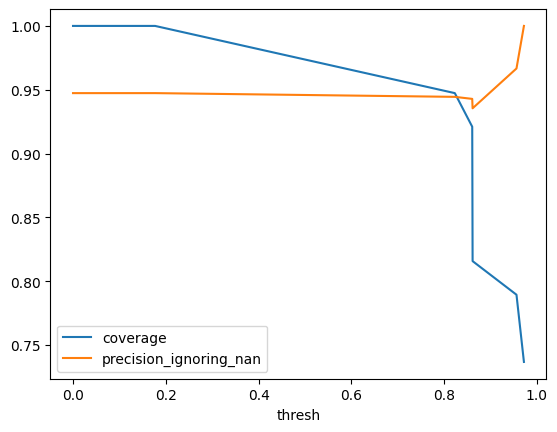

In [12]:
ax = metrics_by_thresh.iloc[:-1].plot(x="thresh")